In [ ]:
#import numpy as np
#from tensorflow import keras
#from tensorflow.keras import layers
#import keras
#from scipy import ndimage
#import matplotlib.pyplot as plt
#import cv2
#import tensorflow as tf
#from keras import backend as K

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
# import keras  <-- Remove this line
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K # <-- Change this import


In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
inp = keras.Input(shape=input_shape)

x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(inp)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dense(units=10)(x)


model = keras.Model(inp, x)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,804,874 (18.33 MB)

 Trainable params: 4,804,874 (18.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Defining KL and loss function from equation 5
lgamma = tf.math.lgamma
digamma = tf.math.digamma

epochs = [1]

def KL(alpha, num_classes=10):
  one = K.constant(np.ones((1,num_classes)),dtype=tf.float32)
  S = K.sum(alpha,axis=1,keepdims=True)

  kl = lgamma(S) - K.sum(lgamma(alpha),axis=1,keepdims=True) +\
      K.sum(lgamma(one),axis=1,keepdims=True) - lgamma(K.sum(one,axis=1,keepdims=True)) +\
      K.sum((alpha - one)*(digamma(alpha)-digamma(S)),axis=1,keepdims=True)

  return kl


def loss_func(y_true, output):
    y_evidence = K.relu(output)
    alpha = y_evidence+1
    S = K.sum(alpha,axis=1,keepdims=True)
    p = alpha / S

    err = K.sum(K.pow((y_true-p),2),axis=1,keepdims=True)
    var = K.sum(alpha*(S-alpha)/(S*S*(S+1)),axis=1,keepdims=True)

    l =  K.sum(err + var,axis=1,keepdims=True)
    l = K.sum(l)


    kl =  K.minimum(1.0, epochs[0]/50) * K.sum(KL((1-y_true)*(alpha)+y_true))
    return l + kl






In [ ]:
batch_size = 1024
import time
start = time.time()
model.compile(loss=loss_func, optimizer="adam", metrics=['accuracy'])
for i in range(30):
  print(i+1)
  model.fit(x_train, y_train, batch_size=batch_size, epochs=1, validation_split=0.1)
  epochs[0]+=1
end = time.time()
print(end - start)

1
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 316ms/step - accuracy: 0.6608 - loss: 621.2319 - val_accuracy: 0.9322 - val_loss: 154.2529
2
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9213 - loss: 173.1371 - val_accuracy: 0.9577 - val_loss: 103.3069
3
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9475 - loss: 119.7177 - val_accuracy: 0.9697 - val_loss: 77.7742
4
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9626 - loss: 88.2542 - val_accuracy: 0.9750 - val_loss: 62.3863
5
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9712 - loss: 70.4177 - val_accuracy: 0.9793 - val_loss: 49.4333
6
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9777 - loss: 55.6443 - val_accuracy: 0.9830 - val_loss: 41.9610
7
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9828 - loss: 46.4920 - val_accuracy: 0.9858 - val_loss: 36.2324
8
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9848 - loss: 40.3934 - val_accuracy: 0.9875 - val_loss: 32.9176
9
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 2

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 3.8003334999084473
Test accuracy: 0.964900016784668


In [ ]:
#calculating probability and uncertinty
def rotate(im,deg):
  #rotation angle in degree
  return ndimage.rotate(im, deg)

def calc_prob_uncertinty(p):

  evidence = np.maximum(p[0], 0)

  alpha = evidence +1

  u = 10/ alpha.sum()
  prob = alpha[np.argmax(alpha)] / alpha.sum()
  return prob, u


1/1 [==============================] - 0s 25ms/step


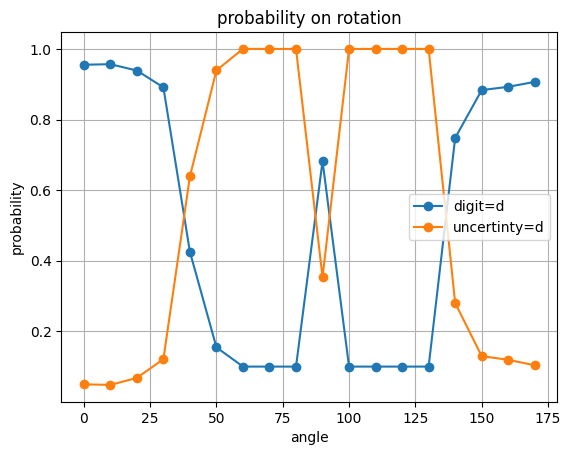

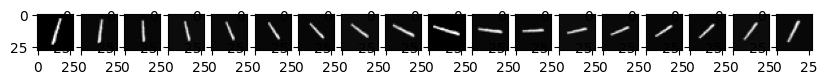

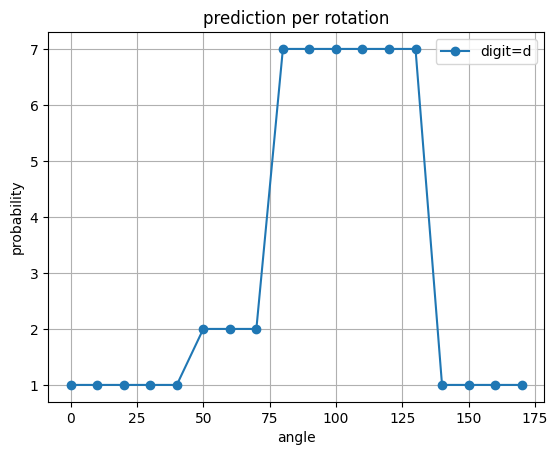

In [ ]:
digit = 1
angles_range = list(range(0,180,10))

test_labels = np.argmax(y_test,axis=1)

predictions = []
uncertinties = []
probabilities= []
imgs = []
for angle in angles_range:

  im = x_test[np.where(test_labels==digit)[0][0]]
  shape = im.shape
  im = rotate(im, angle)
  im = cv2.resize(im,shape[:-1],interpolation = cv2.INTER_AREA)
  imgs.append(im)
  p = model.predict(np.array([im.reshape(shape)]))
  prob, uncertinty = calc_prob_uncertinty(p)
  uncertinties.append(uncertinty)
  probabilities.append(prob)
  predictions.append(np.argmax(p))

plt.plot(angles_range,probabilities, label=f'digit=d',marker='o')
plt.plot(angles_range,uncertinties, label=f'uncertinty=d',marker='o')

plt.xlabel('angle')
plt.ylabel('probability')
plt.legend()
plt.title('probability on rotation')
plt.grid()
plt.show()
f,axs = plt.subplots(1,len(imgs),figsize=(10,20))
for ax,im in zip(axs.ravel(),imgs):
  ax.imshow(im,cmap='gray')
plt.show()

plt.plot(angles_range,predictions, label=f'digit=d',marker='o')
plt.xlabel('angle')
plt.ylabel('probability')
plt.legend()
plt.title('prediction per rotation')
plt.grid()
plt.show()